### This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on MNIST data set. 
If you want to learn more about this work you can also check out this [lecture](https://www.youtube.com/watch?v=4lY-oAY0aQU) from MIT's [6.S191 course](http://introtodeeplearning.com/). 

This cell loads the data and normalizes it to the [0,1] range

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from IPython.display import clear_output, display
import time

# Need to issue either bot %maplotlib inline \n %matplotlib widget or just %matplotlib widget
# %maplotlib ipympl works as well
# %matplotlib inline is to avoid figures to be opened in separate window but to force them within notebook

# %matplotlib inline
# %matplotlib ipympl

In [2]:
mat = scipy.io.loadmat('mnist_all.mat')

Nc=10
N=784
Ns=60000
M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

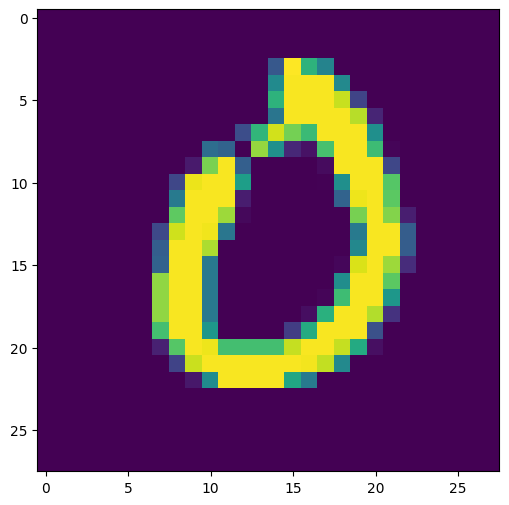

In [3]:
for i in range(3):
    fig=plt.figure(figsize=(6,6))
    plt.imshow(M[i*10].reshape(28, -1))    
    clear_output(wait=True)
    plt.pause(1)

To draw a heatmap of the weights a helper function is created:

In [4]:
def draw_weights(synapses, Kx, Ky, title=''):
    fig=plt.figure(figsize=(12.9,10))
        
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.title(title)
    plt.axis('off')
    # display(fig)
    clear_output(wait=True)    
    plt.pause(0.1)

This cell defines paramaters of the algorithm: `eps0` - initial learning rate that is linearly annealed during training; `hid` - number of hidden units that are displayed as an `Ky` by `Kx` array by the helper function defined above; `mu` - the mean of the gaussian distribution that initializes the weights; `sigma` - the standard deviation of that gaussian; `Nep` - number of epochs; `Num` - size of the minibatch; `prec` - parameter that controls numerical precision of the weight updates; `delta` - the strength of the anti-hebbian learning; `p` - Lebesgue norm of the weights; `k` - ranking parameter. 

In [5]:
eps0=2e-2    # learning rate
Kx=10
Ky=10
hid=Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
mu=0.0
sigma=1.0
Nep=200      # number of epochs
Num=100      # size of the minibatch
prec=1e-30
delta=0.4    # Strength of the anti-hebbian learning
p=2.0        # Lebesgue norm of the weights
k=2          # ranking parameter, must be integer that is bigger or equal than 2

This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

In [9]:
synapses = np.random.normal(mu, sigma, (hid, N))

with open('synapses.pkl', 'rb') as f:
    synapses = pickle.load(f)

In [10]:
def time_governeur(interval, fun):
    mark = time.time()

    def check(is_flush=False):
        nonlocal mark
        t = time.time()
        elapsed = t - mark

        if is_flush or elapsed >= interval:
            fun()
            mark = time.time()

    return check

In [11]:
timed_draw_weights = time_governeur(2, lambda: draw_weights(synapses, Kx, Ky, title=f'Epoch={nep}, {progress:.1f}%'))

for nep in range(Nep):
    eps=eps0*(1-nep/Nep)
    
    # shuffle pictures
    M=M[np.random.permutation(Ns),:]

    # for i in tqdm(range(Ns//Num), leave=False):
    for i in range(Ns//Num):
        # select Num (batch) pictures from shuffled M
        # shape=(28x28,Num)=(784,Num)
        # inputs=np.transpose(M[i*Num:(i+1)*Num,:]) 
        inputs = M[i*Num:(i+1)*Num,:].T
        sig=np.sign(synapses)

        # compute raw reaction of each neuron to image in batch
        # <W,v>, shape=(hid,Num)=(100,100)
        # tot_input=np.dot(sig * np.absolute(synapses) ** (p-1), inputs) 
        tot_input = (sig * np.absolute(synapses) ** (p-1)) @ inputs
        
        # compute yl=g(i), eq. [10], shape=(hid,Num)=(100,100)
        y=np.argsort(tot_input,axis=0) # argsort each column of tot_input => each col. of y will have indices of hid. units in ascending order by reaction strength to particular image in batch
        yl=np.zeros((hid,Num))
        # y[hid-1,:] - indices of most strong neurons relative to each image in batch
        # y[hid-1,:],np.arange(Num) -> [[most_strong_neuron_for_image_0, 0], [most_strong_neuron_for_image_1, 1], ..., [most_strong_neuron_for_image_n, n]]
        # y[hid-k] - weakly reacted neuron (single one!)
        # as such yl will be a sparse matrix (most zeros) where each column has single 1 and single -0.4.
        yl[y[hid-1],np.arange(Num)]=1.0     
        yl[y[hid-k],np.arange(Num)]=-delta
        # assert np.all(y[hid-1,:] == y[hid-1])
        # assert np.all(np.count_nonzero(yl == 1, axis=0) == 1) # each column has single 1
        # assert np.all(np.count_nonzero(yl == -delta, axis=0) == 1) # each column has single -0.4

        # xx=np.sum(np.multiply(yl,tot_input),axis=1)
        
        # reaction of each neuron relative to a whole batch of images (cumulative reaction of neuron)
        # apply yl (aka mask) - it will eventually zero out most of reactions, but scaling remaining ones with either 1 or -delta
        xx = yl * tot_input
        # shape=(hid)=100 => i.e. vector
        xx = xx.sum(axis=1)
        # assert np.all(np.isclose(xx, np.diag(yl @ tot_input.T)))
        # assert np.all(np.isclose(xx, np.sum(np.multiply(yl,tot_input),axis=1)))
        
        # ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses)

        # virtual image (input) for each of the hid neurons. Virtual image = weighted (and masked) by yl images from batch
        # the point is that we want to pretend like there is no batch images but just a single image.
        # In case there is no batch really (e.g. online algo where images are processed one by one)
        # ds_subtrahend would be just sparse matrix with only 2 rows:
        # 1) one row would contain image as is for where yl[i] == 1
        # 2) second row would contain discounted image for where yl[i] == -0.4
        # shape=(hid,28x28)=(100,784)
        ds_subtrahend = yl @ inputs.T
        # assert np.all(ds_subtrahend == np.dot(yl,np.transpose(inputs)))

        # yy - broadcasted xx vector (reaction of each neuron)
        # xx[:,np.newaxis] - turn vector to single column matrix
        # np.tile - copy column xx[:,np.newaxis] N times, i.e. broadcast
        # shape=(hid,28[28)=(100,784)
        # yy = np.tile(xx[:,np.newaxis], (1,N))
        ds_subtractor = (synapses.T * xx).T
        # assert np.all(ds_subtractor == np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses))
        # implementation of: g(v_i - <W,v>*W_i) = g*v_i - g*<W,v>*W_i
        # v_i - i-th element of input (i-th pixel)
        # <W,v> - reaction of neuron to whole image
        # W_i - i-th synapse
        ds = ds_subtrahend - ds_subtractor

        # Нормировка прям как у Редозубова =)
        # nc = np.amax(np.absolute(ds))
        nc = np.absolute(ds).max()
        
        if nc<prec:
            nc=prec
        
        # synapses += eps*np.true_divide(ds,nc)
        synapses += eps * (ds / nc)
        
        progress = (i / (Ns//Num)) * 100
        timed_draw_weights()

    timed_draw_weights(is_flush=True)

KeyboardInterrupt: 

In [ ]:
assert False
with open('synapses.pkl', 'wb') as f:
    pickle.dump(synapses, f)